In [87]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
project_dir = Path(os.environ['CONDA_PREFIX']).parent.absolute()
current_dir = project_dir / 'scratch/ana/result/sbtTime'

In [89]:
files = sorted(list(current_dir.glob('*.txt')))
df_list = [pd.read_csv(str(f), sep=r'\s+', header=None, names=['iEvt', 'sbt1', 'sbt2']) for f in files]

for i in range(len(df_list)):
    df_list[i].astype({'iEvt': 'float64', 'sbt1': 'float64', 'sbt2': 'float64'})
    
df_sbt1_list = [
    pd.DataFrame({'x' : df['iEvt'], 'y' : df['sbt1']}) for df in df_list
]
df_sbt2_list = [
    pd.DataFrame({'x' : df['iEvt'], 'y' : df['sbt2']}) for df in df_list
]


In [90]:
total_events = 0
for i in range(len(df_sbt1_list)):
    df_sbt1_list[i]['x'] += total_events
    df_sbt2_list[i]['x'] += total_events
    total_events += len(df_sbt1_list[i])

df_sbt1_list = {idx + 1036 : df for idx, df in enumerate(df_sbt1_list)}
df_sbt2_list = {idx + 1036 : df for idx, df in enumerate(df_sbt2_list)}

In [91]:
def rebin(df, bins, range_):
    hist, edges = np.histogram(
        df.x.values, 
        weights=df.y.values,
        bins=bins, 
        range=range_
    )
    entries, _ = np.histogram(
        df.x.values,
        bins=bins, 
        range=range_
    )

    hist = hist.astype('float64')
    entries = entries.astype('float64')

    return pd.DataFrame({
        'x' : 0.5 * (edges[:-1] + edges[1:]),
        'y' : np.divide(hist, entries, out=np.zeros_like(hist), where=entries!=0)
    })

In [92]:
binning = 2500
df_sbt1_rebin = {}
df_sbt2_rebin = {}

total_events = 0
for idx, df in df_sbt1_list.items():
    df = df.copy()
    rangeh = np.ceil(((df.x.values[-1] + 1)) / 10000) * 10000
    rangel = np.floor((df.x.values[0] + total_events)  / 10000) * 10000
    nbins = int((rangeh - rangel) / binning)
    print(idx, rangel, rangeh, nbins)
    
    df_sbt1_rebin[idx] = rebin(df, nbins, (rangel, rangeh))
    df_sbt2_rebin[idx] = rebin(df_sbt2_list[idx], nbins, (rangel, rangeh))


1036 0.0 60000.0 24
1037 50000.0 120000.0 28
1038 110000.0 120000.0 4
1039 110000.0 180000.0 28
1040 170000.0 220000.0 20
1041 210000.0 250000.0 16
1042 240000.0 330000.0 36
1043 320000.0 390000.0 28
1044 380000.0 400000.0 8
1045 390000.0 550000.0 64
1046 540000.0 670000.0 52
1047 660000.0 680000.0 8
1048 670000.0 750000.0 32


In [93]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, len(df_sbt1_rebin))]

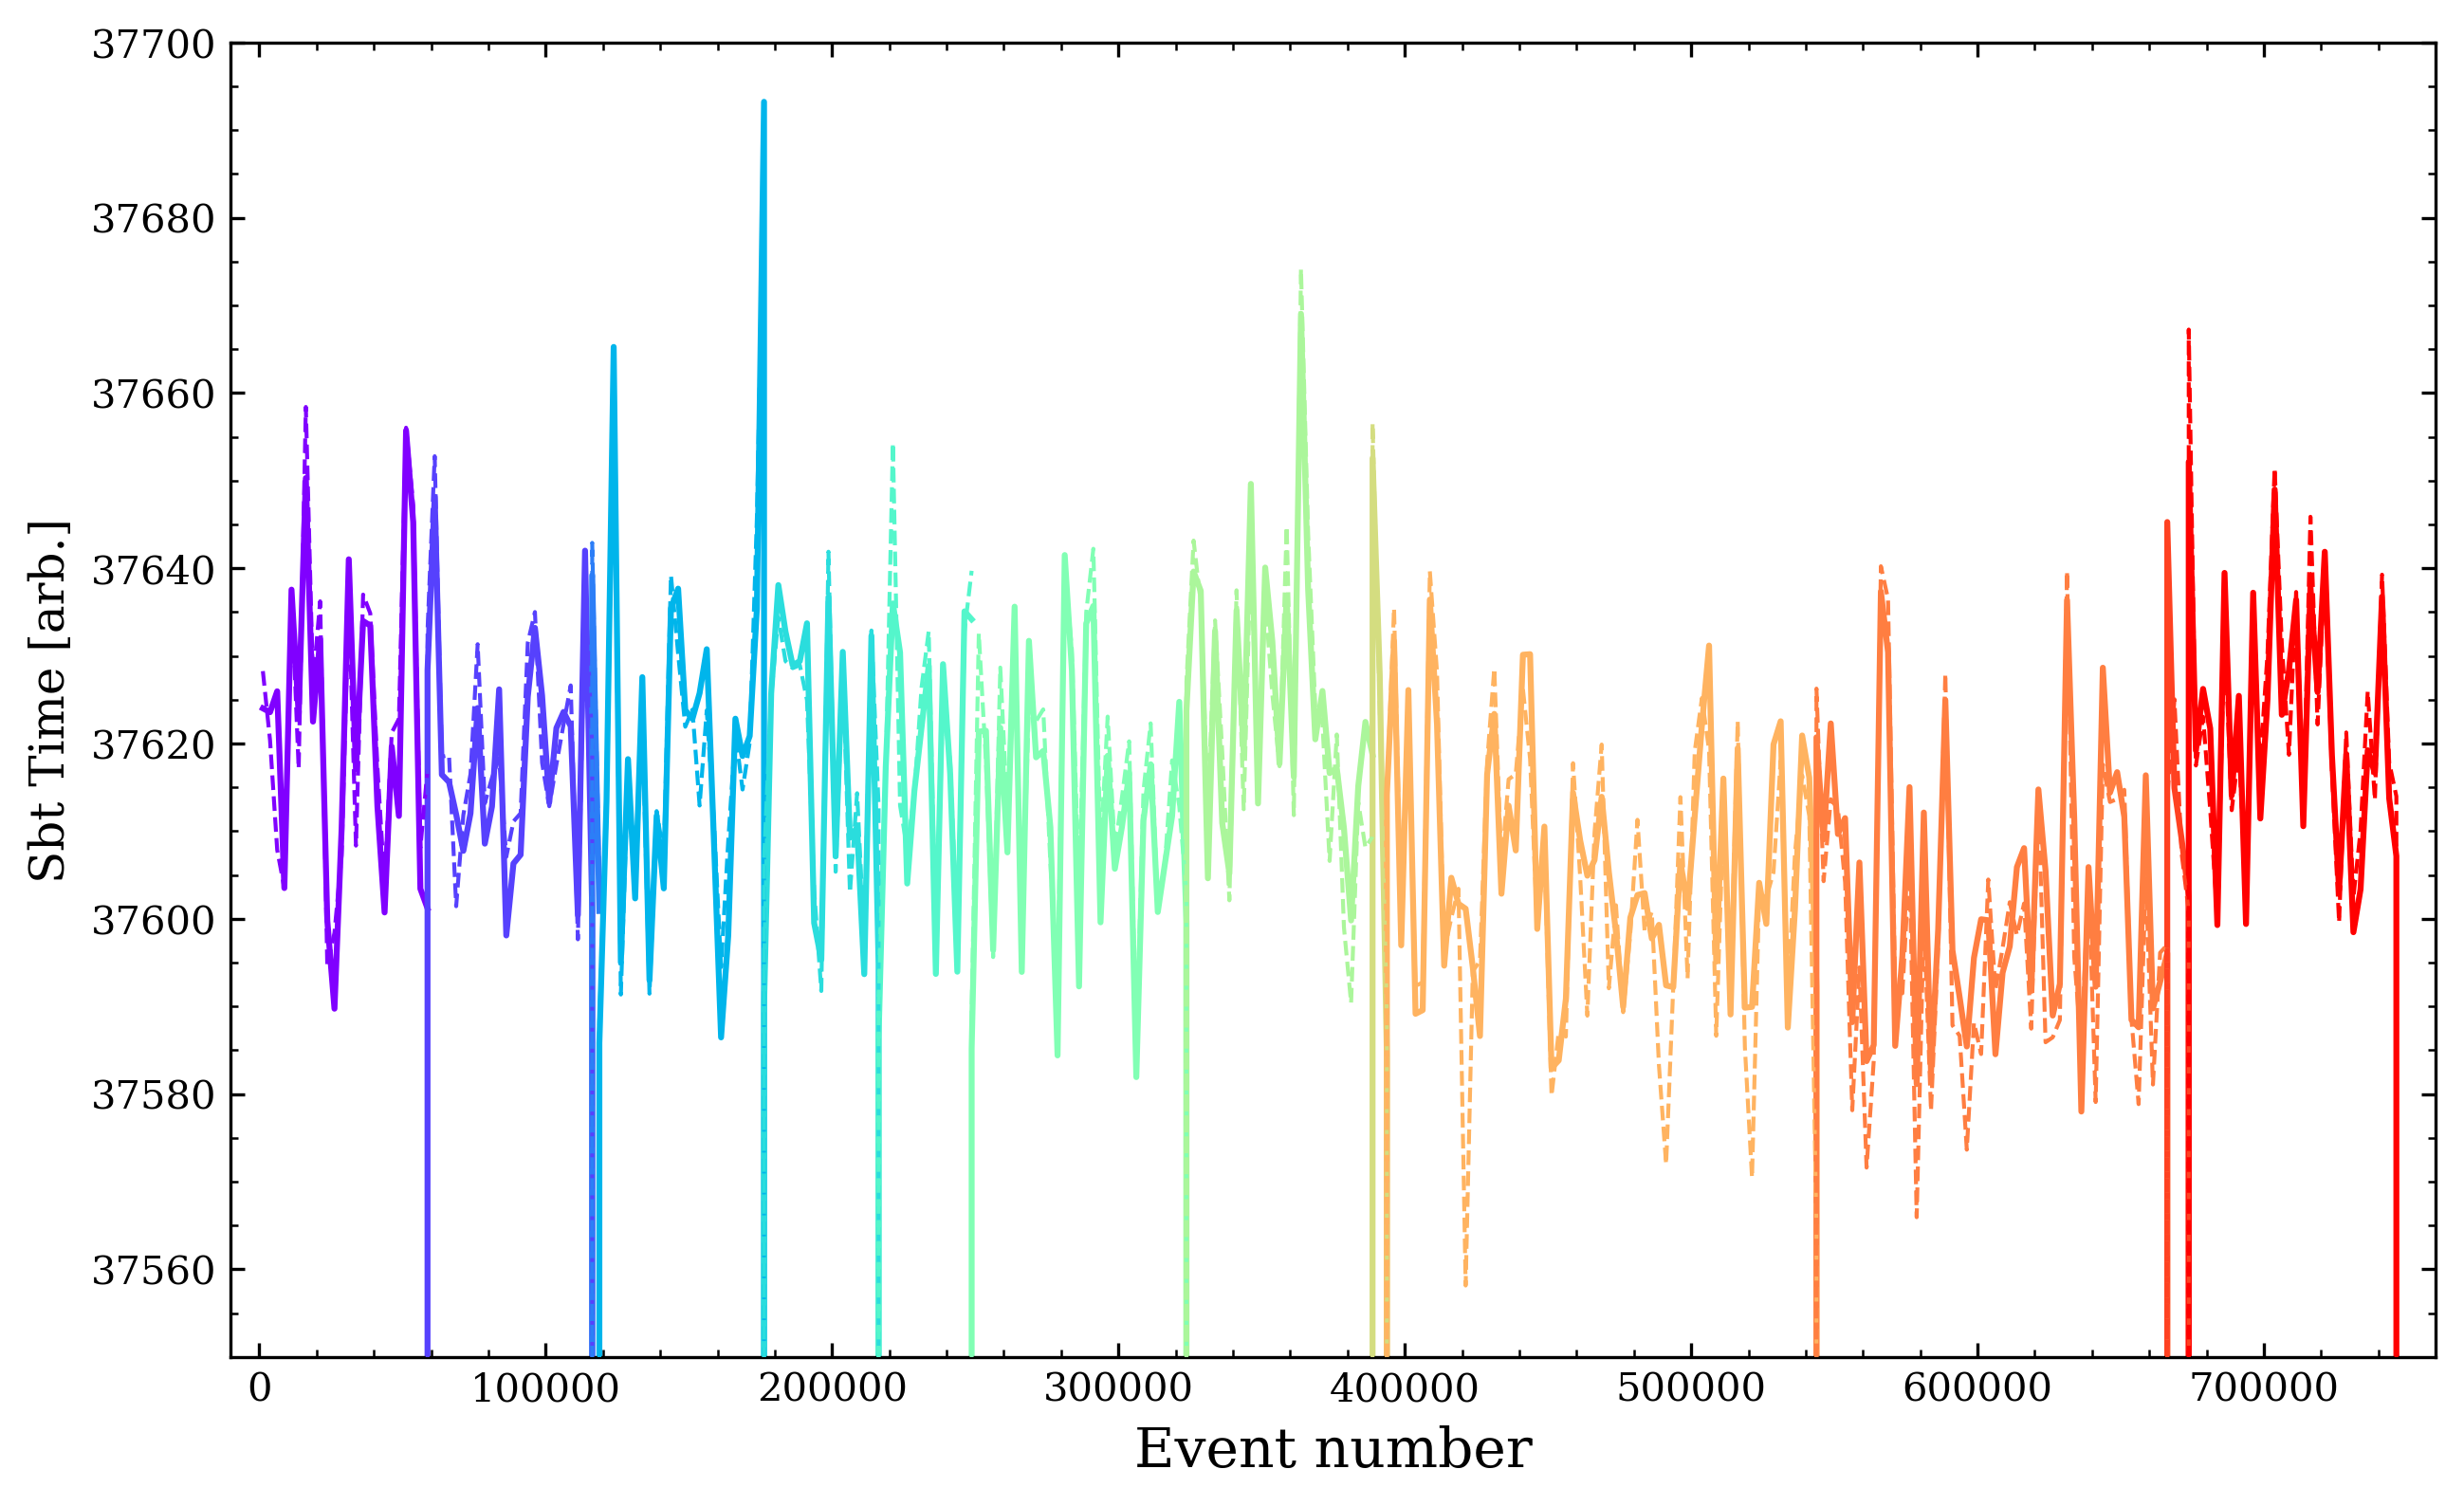

In [97]:
fig, ax = plt.subplots(
    figsize=(10, 6),
    facecolor='white',
    dpi=300,
)

for idx, irun in enumerate(df_sbt1_rebin.keys()):
    # print(len(df_sbt1_rebin[irun]))
    # print(df_sbt1_rebin[irun].x.values[-1])
    # if irun != 1045:
    #     continue
    ax.plot(
        df_sbt1_rebin[irun].x.values,
        df_sbt1_rebin[irun].y.values,
        color=colors[idx],
        # label=f'Run {idx}',
    )

    ax.plot(
        df_sbt2_rebin[irun].x.values,
        df_sbt2_rebin[irun].y.values,
        color=colors[idx],
        linestyle='--',
        linewidth=1,
        zorder=10
        # label=f'Run {idx}',
    )

ax.set_xlim(-10000, 760000)
ax.set_ylim(37550,37700)
ax.set_xlabel('Event number', fontsize=14)
ax.set_ylabel(
    r'Sbt Time [arb.]', 
    fontsize=12
)

# ax.annotate(
#     'SBT 1 (thin)',
#     xy=(0.1, 0.9),
#     xycoords='axes fraction',
#     fontsize=12,
#     ha='left',
#     va='top',
#     bbox=dict(
#         boxstyle='round',
#         edgecolor='black',
#         facecolor='white',
#         alpha=0.1
#     )
# )

# ax.annotate(
#     'SBT 2 (thick)',
#     xy=(0.1, 0.3),
#     xycoords='axes fraction',
#     fontsize=12,
#     ha='left',
#     va='top',
#     bbox=dict(
#         boxstyle='round',
#         edgecolor='black',
#         facecolor='white',
#         alpha=0.1
#     )
# )

plt.show()

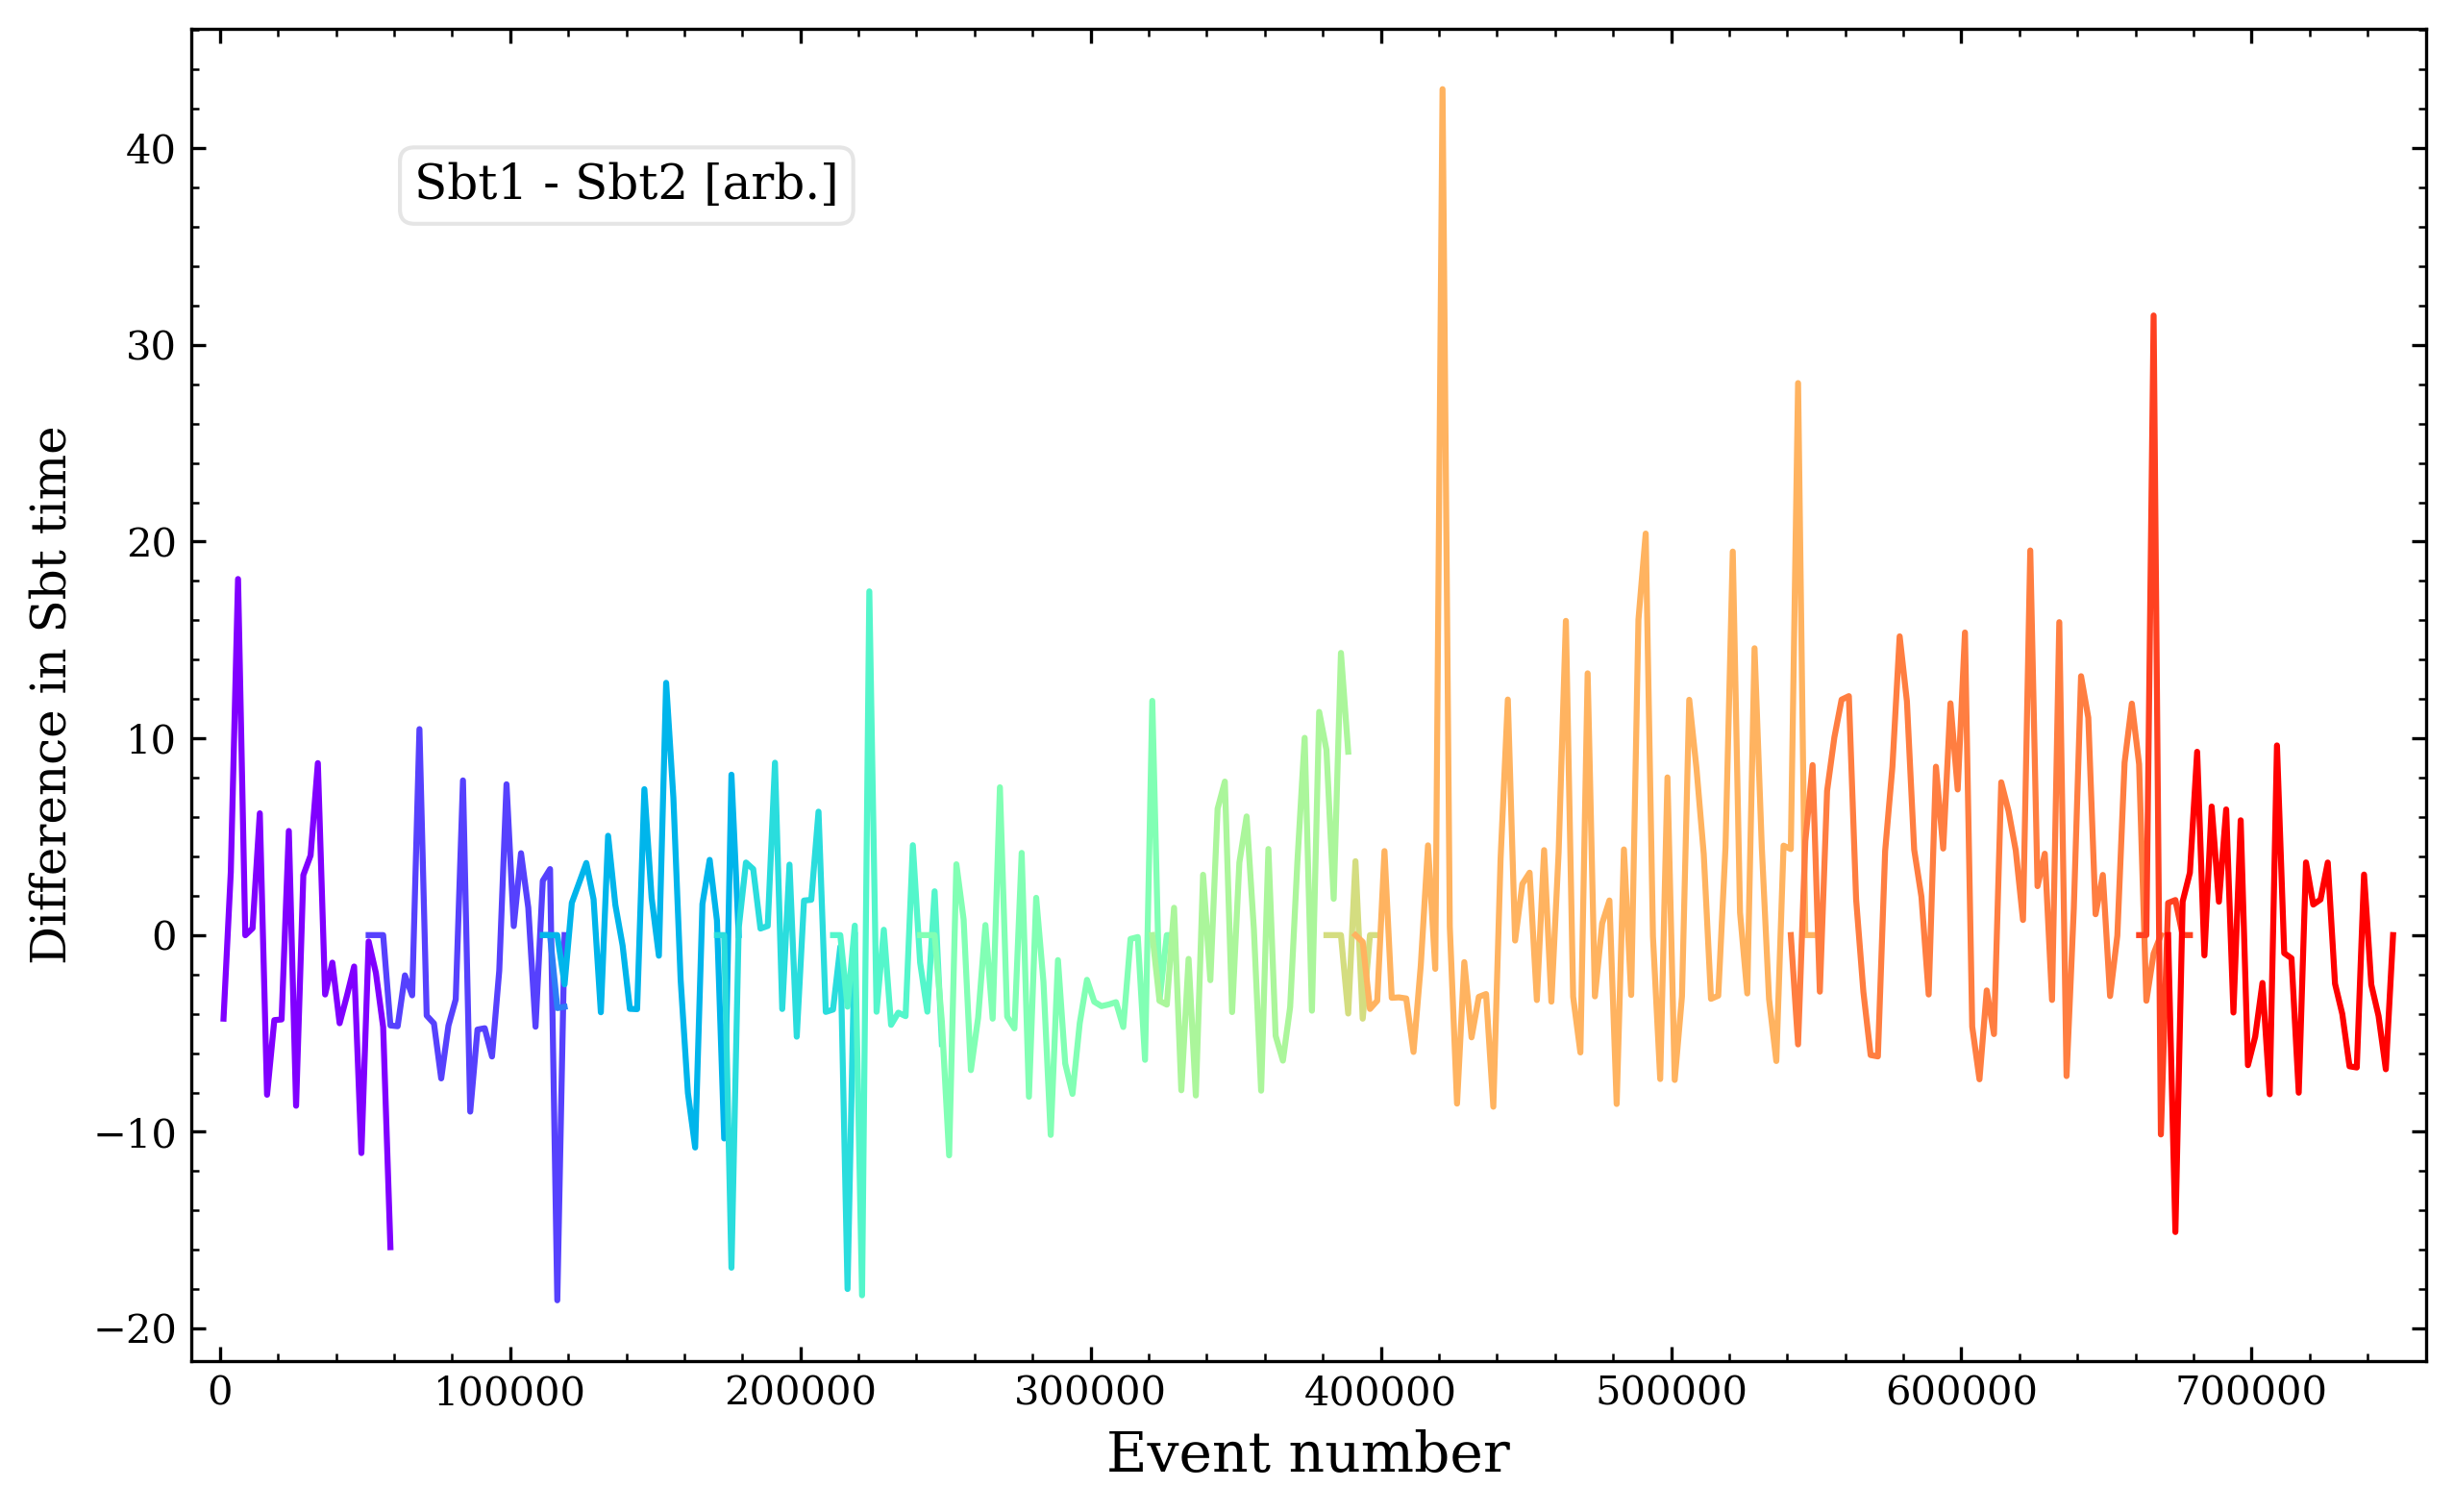

In [99]:
fig, ax = plt.subplots(
    figsize=(10, 6),
    facecolor='white',
    dpi=300,
)

for idx, irun in enumerate(df_sbt1_rebin.keys()):
    ax.plot(
        df_sbt1_rebin[irun].x.values,
        df_sbt1_rebin[irun].y.values - df_sbt2_rebin[irun].y.values,
        color=colors[idx],
        # label=f'Run {idx}',
    )

ax.set_xlim(-10000, 760000)
# ax.set_ylim(350,500)
ax.set_xlabel('Event number', fontsize=14)
ax.set_ylabel(
    'Difference in Sbt time',
    fontsize=12
)

ax.annotate(
    r'Sbt1 - Sbt2 [arb.]',
    xy=(0.1, 0.9),
    xycoords='axes fraction',
    fontsize=12,
    ha='left',
    va='top',
    bbox=dict(
        boxstyle='round',
        edgecolor='black',
        facecolor='white',
        alpha=0.1
    )
)

plt.show()